In [2]:
import cv2 
import numpy as np
import matplotlib.pylab as plt
import math 
from function import SelectShapeStd
def showC(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,cmap="gray")
    
def show(img):
    plt.imshow(img,cmap="gray")

# **Week10_1**
1. Adaptive Thresholding (Variance of Thresholding)
2. Binary Thresholding (Variance of Thresholding)
3. PolarTransformation

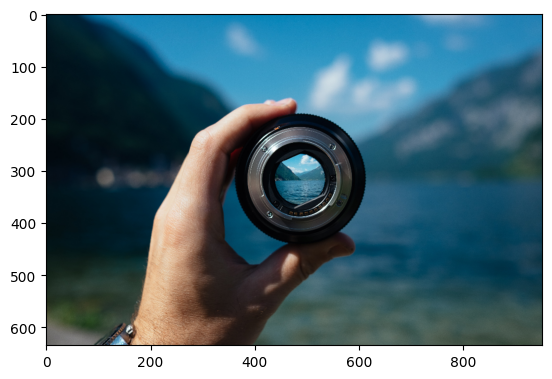

In [4]:
img = cv2.imread("images/lens.png")
gray = cv2.imread("images/lens.png",0)
showC(img)

# **Adaptive Thresholding (Variance of Thresholding)**

1. mode  = mean
2. mode  = gaussian

$$ G(x, y) = \frac{1}{2\pi \sigma_X \sigma_Y} \exp\left(-\frac{(x-center)^2}{2\sigma_X^2} - \frac{(y-center)^2}{2\sigma_Y^2}\right) $$

x- center, y-center: khoang cach tu pixel dang xet toi pixel trung tam cua kernel, cang xa gia tri trung tam, gia tri cua exp cang giam, cang gan thi gia tri cang lon


In [169]:
def add_padding (img, padding):
    
    new_height = img.shape[0] + 2*padding
    new_width = img.shape[1] + 2*padding
    
    image_padding = np.zeros((new_height,new_width ), dtype = np.uint8)
    image_padding[padding : new_height - padding,padding : new_width- padding] = img
    
    return image_padding


def kernel_gaussian(kernel_size = 3, sigma = 1):
    
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float16)
    
    center = kernel_size // 2
    
    for y in range(kernel_size):
        for x in range(kernel_size):
            
            coefficient = 1 / (2 * np.pi * sigma * sigma)
            exponent = -(((x-center) ** 2) / (2 * sigma ** 2) + ((y-center) ** 2) / (2 * sigma ** 2))
            gau_value = coefficient * np.exp(exponent)
            
            
            kernel[y,x] = gau_value
            
            
    return kernel / np.sum(kernel)


In [168]:
k= kernel_gaussian(kernel_size = 5, sigma = 1)
k

array([[6.6101e-02, 1.0895e-01, 6.6101e-02, 1.4740e-02, 1.2093e-03],
       [1.0895e-01, 1.7957e-01, 1.0895e-01, 2.4307e-02, 1.9951e-03],
       [6.6101e-02, 1.0895e-01, 6.6101e-02, 1.4740e-02, 1.2093e-03],
       [1.4740e-02, 2.4307e-02, 1.4740e-02, 3.2883e-03, 2.6989e-04],
       [1.2093e-03, 1.9951e-03, 1.2093e-03, 2.6989e-04, 2.2173e-05]],
      dtype=float16)

In [56]:
def adaptive_threhold(gray, block_size = 3, minus_c = 2, mode = "mean", mode_threshold ="binary"):
    
    adaptive_space  = np.zeros((gray.shape[0],gray.shape[1]), dtype = np.uint8)
    
    gray_padding = add_padding(gray, block_size //2 )
    padding = block_size //2 
    
    k = kernel_gaussian(kernel_size = block_size, sigma = 1)
    
    for y in range(padding, gray.shape[0] + padding):
        for x in range(padding, gray.shape[1] + padding):
            
            crop = gray_padding[y -padding : y + padding + 1 , x -padding : x + padding + 1]
            
            
            if mode =="mean":
                threshold = np.mean(crop) - minus_c
                pass
            elif mode =="gaussian":
                threshold = np.sum(crop* k)
                pass
            
            
            if gray_padding[y,x] > threshold:
                if mode_threshold =="binary":
                    adaptive_space[y-padding, x -padding] = 255
                elif mode_threshold =="binary_inv":
                    adaptive_space[y-padding, x -padding] = 0
                    
            elif gray_padding[y,x] <= threshold:
                if mode_threshold =="binary":
                    adaptive_space[y-padding, x -padding] = 0
                elif mode_threshold =="binary_inv":
                    adaptive_space[y-padding, x -padding] = 255
                    
            
    return adaptive_space  
    

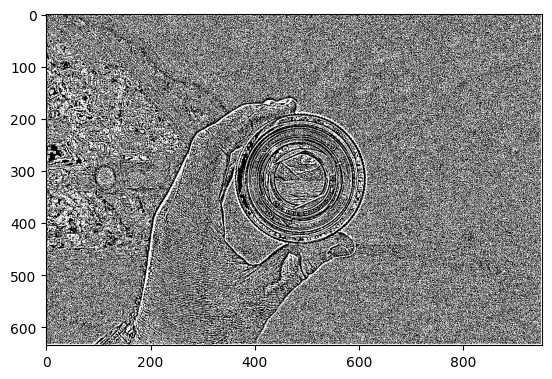

In [58]:
adaptive = adaptive_threhold(gray,block_size = 5, minus_c = 2, mode = "gaussian", mode_threshold ="binary")
show(adaptive)

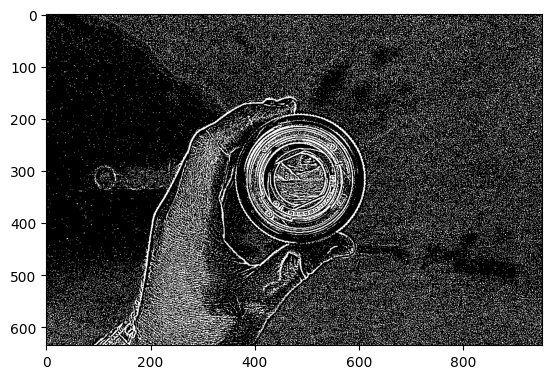

In [30]:
adaptive_t = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5 , 2)
showC(adaptive_t)

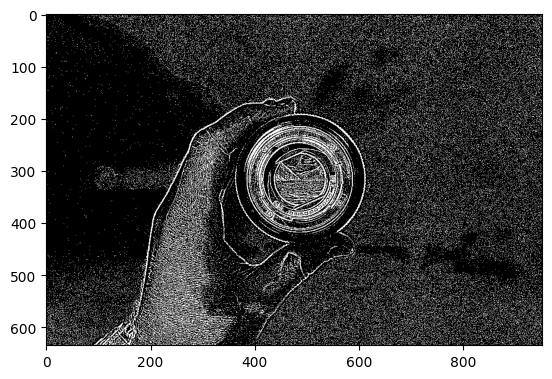

In [59]:
adaptive_t = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5 , 2)
showC(adaptive_t)

# **Binary Thresholding (Variance of Thresholding)**

## OTSU Algorithm
* Step1: Histogram Calculation
* Step2: Cluster histogram -> C1 và C2  (clustering: Phân cụm)
* Step3 :Calculate weight1 w1, weight2 w2
$$w_1(t) = \sum_{i=1}^{t}P(i)$$
$$w_2(t) = \sum_{i=t+1}^{I}P(i)$$

P(i):$$P(i) = \frac{n_i}{N}.$$

* Calculate mean for C1, C2
$$\mu_1(t) = \sum_{i=1}^{t}\frac{iP(i)}{w_1(t)}$$
$$\mu_2(t) = \sum_{i=t+1}^{I}\frac{iP(i)}{w_2(t)}$$
* Step4: Calculate between variance
$$\sigma_b^2(t) = w_1(t)w_2(t)[\mu_1(t) - \mu_2(t)]^2.$$

* Update between variance with maximum value -> return T threshold

In [66]:
histogram, _ = np.histogram(gray, bins = 256, range = [0,256])
histogram[: 10]
[0,1,2,3,4,5,6,7,8,9]

m = np.arange(0,10,1)
np.sum(m * histogram[: 10])

105988

In [70]:
def binary_threshold(img):
    height , width = img.shape[0], img.shape[1]
    
    T =  0 
    # Tinh histogram của ảnh 
    histogram, _ =  np.histogram(img, bins = 256, range = [0,256])
    
    max_variance = 0
    
    for t in range(256):
        
        # Ting trong so w ( tinh tong so luong pixel ben trai va ben phai )
        total_pixel_left = np.sum(histogram[:t])
        total_pixel_right = np.sum(histogram[t:])
    
        # Tinh mean
        mean_left  = np.sum(np.arange(t) * histogram[:t]) / total_pixel_left
        mean_right = np.sum(np.arange(t, 256) * histogram[t:]) / total_pixel_right
        
        # tinh do lech ( lay do lon)
        variance = total_pixel_left * total_pixel_right * ((mean_left -mean_right )** 2)
        
        if variance > max_variance:
            max_variance = variance
            T = t 
            
    return T - 1     

In [72]:
T = binary_threshold(gray)
T

C:\Users\manmu\AppData\Local\Temp\ipykernel_14016\1782756477.py:17: RuntimeWarning: invalid value encountered in longlong_scalars
  mean_left  = np.sum(np.arange(t) * histogram[:t]) / total_pixel_left


91

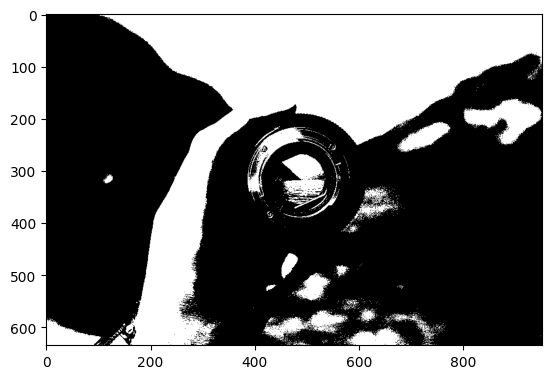

In [77]:
_, threshold = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)
show(threshold)

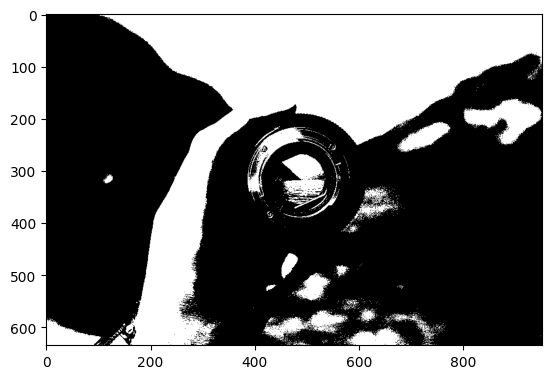

In [78]:
T_auto, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
T_auto
show(threshold)

# **Polar Tranaformation**
$$x = center_x + r * cos(\alpha)$$
$$y = center_y + r * sin(\alpha)$$


In [94]:
math.cos(math.radians(45))
height, width = img.shape[0] , img.shape[1]
print(int(math.sqrt((height/2)**2 + (width/2)**2)) + 20)

592


In [149]:
def polar_transfrom(img):
    
    height, width = img.shape[0] , img.shape[1]
    
   
    max_r = int(math.sqrt((height/2)**2 + (width/2)**2)) + 20
    print(f'max r: {max_r}')
    
    center_x = width // 2 
    center_y = height // 2 
    theta =360
    polar_space = np.zeros((max_r, theta), dtype=np.int16)
    
    for the in range(theta):
        for r in range(max_r*2):
            
            x = int(center_x +  r * np.cos(np.radians(the)))
            y = int(center_y +  r * np.sin(np.radians(the)))
            
            
            if 0 <= x <width and 0 <= y < height:
                
                polar_space[r,the] = img[y, x]
            
    
    return polar_space.astype(np.uint8)

def polar_to_2d(r, theta,center):
    center_x = center[0]
    center_y = center[1]
    
    x = int(center_x +  r * np.cos(np.radians(theta)))
    y = int(center_y +  r * np.sin(np.radians(theta)))
    
    return x, y
    
    

In [ ]:
show(gray)

max r: 592


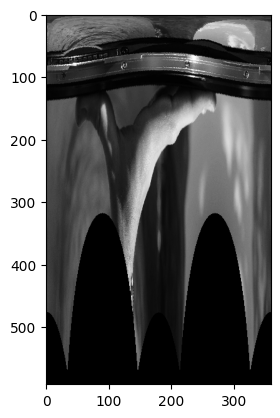

In [122]:
imgpolar  = polar_transfrom(gray)
show(imgpolar)

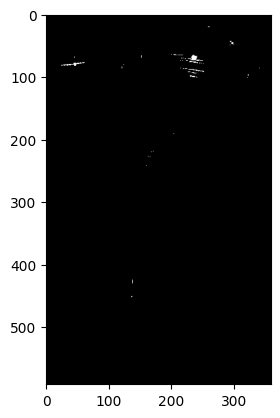

In [172]:
_ , threshold = cv2.threshold(imgpolar, 230, 255, cv2.THRESH_BINARY)
show(threshold)

In [142]:
from function import *
def ClosingCircle(image, radius):
    mask = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2*radius + 1, 2*radius +1))
    dilation = cv2.dilate(image, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    closing = cv2.erode(dilation, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return closing

index:13
225 63 28 18


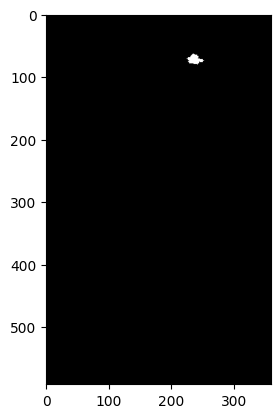

In [173]:
closing  = ClosingCircle(threshold,5)

biggest = SelectShapeStd(closing)

x,y,w,h = cv2.boundingRect(dilation)

print(x,y,w,h)
imgpolar_copy = imgpolar.copy()
cv2.rectangle(imgpolar_copy, (x,y),(x+w, y+h), (255), 2)

show(dilation)

In [174]:
x1_2d, y1_2d = polar_to_2d(y, x, (img.shape[1] //2, img.shape[0]//2))

x2_2d, y2_2d = polar_to_2d(y+ h, x+w, (img.shape[1] //2, img.shape[0]//2))

print(x_2d, y_2d)

434 269


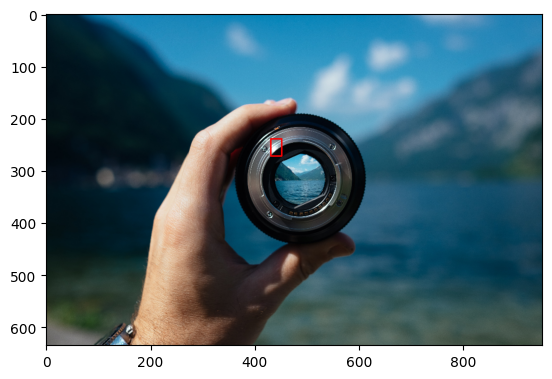

In [175]:
img_copy = img.copy()

cv2.rectangle(img_copy, (x1_2d,y1_2d),(x2_2d, y2_2d), (0, 0, 255), 2)

showC(img_copy)